<h2 style="text-align:center;color:Red;">Intro & Objectif 🎯🎯</h2>

<h3 style="text-align:center;">        In this project, we will be detecting customer behaviour on products, does he purchase, add to cart or just view the item? We are given a list of  users' events, and each event should be done on a specefic product in a specefic time and so on, it's related to products and users. </h3>
<h3 style="text-align:center;"> The dataset we are working on contains normally around 60 000 000 record, but we will be using just 5 000 000 for memory purposes.</h3>
<h3> Brief, to understand better the dataset, it is about a user userid during session usersession added to shopping cart (property eventtype is equal cart) product productid of brand brand of category categorycode (categorycode) with price price at event_time
<h2 style="text-align:center;color:Red;">Project Pipeline 📚📚</h2>

>The various steps involved in the Machine Learning Pipeline are :

  **1. `Import Libraries & Data`**.

  **2. `EDA`**.

  **3. `Preprocessing`**.

  **4. `Data Visualization of Target Variables`**.

  **5. `Data Preprocessing`**.

  **6. `Splitting Data`**.

  **7. `Model Training & Evaluation`**.

<p style="background-color:pink; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Importing Libraries & Data</b></p> 

In [98]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import sum,avg,max,min,mean,count, col
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('fivethirtyeight')

In [99]:
# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('Spark Application') \
                    .getOrCreate()

In [100]:
# read the data
df = spark.read.csv('ecommerce3.csv',
                         sep=',',
                         header=True)

# View the first five records
df.show(5)

+--------+--------------------+----------+----------+-------------------+--------------------+---------+------+---------+--------------------+
|     _c0|          event_time|event_type|product_id|        category_id|       category_code|    brand| price|  user_id|        user_session|
+--------+--------------------+----------+----------+-------------------+--------------------+---------+------+---------+--------------------+
|10257365|2019-10-09 02:46:...|      view|  29900078|2059484601444729123|                null|     peda|1647.4|532353313|47059489-3a63-435...|
|28875143|2019-10-21 16:17:...|      view|   1801805|2053013554415534427|electronics.video.tv|    artel| 231.6|536042235|a65ee34b-7701-4b2...|
|28709595|2019-10-21 14:42:...|      cart|   1004870|2053013555631882655|electronics.smart...|  samsung|284.02|517143806|a9ba13a7-afac-41c...|
| 3458568|2019-10-03 18:40:...|      view|   5701087|2053013553970938175|auto.accessories....|      jvc| 51.48|556492770|799d5c0a-e1f3-4f2...|

<p style="background-color:pink; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>EDA</b></p> 

## Goal :
- Understand our data as well as possible (a small step forward is better than a big step back)

## Basic Analysis :
- **The various columns present in the dataset and their meaning** :
    - `event_time` : Time when event happened at (in UTC).

    - `event_type` : Only one kind of event: purchase.

    - `product_id` : ID of a product

    - `category_id`	: Product's category ID

    - `category_code` : Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.

    - `brand` : Downcased string of brand name. Can be missed.

     - `price` : Float price of a product. Present.

    - `user_id` : Permanent user ID.

    - `user_session` : Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.
    
- **Target variable** : event_type
- **Number of rows / columns** : 5,000,000 / 10
- **NaN values** : no missing values in the whole dataset

### Basic Preprocessing :
- **Types of variables** : the price is considered as String, so we turn it into Double type

### Visualizations & Correlations :
- **Target variable values** : purchase, card, view
- **How many customers visit the site** :  1498122 user
- **Relationship between date and traffic of users** : More users are active in the day 14 in the chosen month when compared to the other days
- **Fidelity of users in the dataset** : 86978 user buy a product after viewing it, and there are 10,085 repeat customers, who bought more than once.
- **The most popular brands** : samsung, apple, xiaomi, huawei then lucente.
- **The most visited categories** : electronic smartphones and clocks.
- **prices of products based on customers behaviours** : users react in the same way with a products from different ranges of prices, but they almost just view the product and don't purchase it.

### Basic Analysis

In [6]:
# Get columns names
print(f"The data contain the following features : {df.columns}" )

The data contain the following features : ['_c0', 'event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']


In [7]:
# Get number of records
print("The data contain %d records." % df.count())

The data contain 5000000 records.


In [8]:
# Get number of columns
print("The data contain %d columns." % len(df.columns))

The data contain 10 columns.


In [9]:
# Schema of the data
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [10]:
# Let's check how many NaN values we have in each column
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|_c0|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+---+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|  0|         0|         0|         0|          0|            0|    0|    0|      0|           0|
+---+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



In [11]:
# show statisctics about our dataset
df.describe().show()

+-------+--------------------+--------------------+----------+--------------------+--------------------+-------------------+-------+------------------+--------------------+--------------------+
|summary|                 _c0|          event_time|event_type|          product_id|         category_id|      category_code|  brand|             price|             user_id|        user_session|
+-------+--------------------+--------------------+----------+--------------------+--------------------+-------------------+-------+------------------+--------------------+--------------------+
|  count|             5000000|             5000000|   5000000|             5000000|             5000000|            3408723|4279526|           5000000|             5000000|             5000000|
|   mean|     2.12270030347E7|                null|      null|  1.05501520227192E7|2.057409086935276...|               null|   null|290.42266973796785| 5.335356617042858E8|                null|
| stddev|1.2256005347741628E7|

### Basic Preprocessing

- As we saw above, the price is a String variable by default, so we turn it to double type. 
- THe dataset contains duplicated data, so we remove these ones to be more precise in prediction.

In [101]:
# convert the price to double type
df = df.withColumn("price", df.price.cast(DoubleType()))

In [13]:
# let's check again column data types
df.dtypes

[('_c0', 'string'),
 ('event_time', 'string'),
 ('event_type', 'string'),
 ('product_id', 'string'),
 ('category_id', 'string'),
 ('category_code', 'string'),
 ('brand', 'string'),
 ('price', 'double'),
 ('user_id', 'string'),
 ('user_session', 'string')]

In [102]:
# remove rows with duplicated features : ['event_type', 'product_id','price', 'user_id','user_session']
df = df.drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])

In [15]:
# let's see how many records we have now
print(f'The dataset contains {df.count()} record after removing duplicated ones.')

The dataset contains 4708152 record after removing duplicated ones.


In [103]:
# we remove the first insignificant column _c0
df = df.drop('_c0')

### Visualizations & Correlations

- **Target variable values** :

In [17]:
# different values for our taret variable
df.select(['event_type','user_id']).groupBy('event_type').agg(count('user_id')).show()

+----------+--------------+
|event_type|count(user_id)|
+----------+--------------+
|  purchase|         86978|
|      view|       4520837|
|      cart|        100337|
+----------+--------------+



 - **How many customers visit the site?**

In [18]:
nb_of_users = df.select('user_id').distinct().count()
print(f'There are {nb_of_users} user!')

There are 1498122 user!


- **Does the date affect the traffic of users?**

In [19]:
traffic_df = df.select(['event_time','user_id']).toPandas()

In [20]:
traffic_df['event_time'] = traffic_df['event_time'].apply(lambda s: str(s)[0:10])

In [21]:
visitor_by_date = traffic_df.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


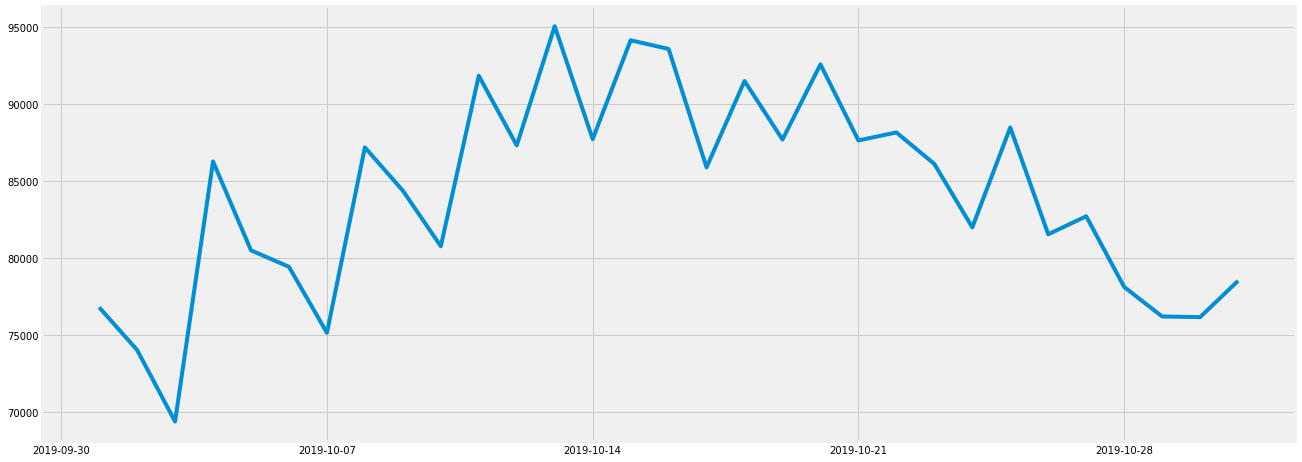

In [22]:
# show the users traffic during time 
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()

- **How many customers buy a product after viewing or adding it to card?**

In [23]:
# get the number of items purchased
df = df.withColumn('Purchased', df["event_type"]=="purchase")

df.groupBy("Purchased").count().show()

+---------+-------+
|Purchased|  count|
+---------+-------+
|     true|  86978|
|    false|4621174|
+---------+-------+



- **Does our custumers buy more than one time?**

In [104]:
# get dataset of users who really buy products
purchase_df = df.filter(df['event_type']=='purchase')
# get the number of purchases and sales of each user
Customer_table=purchase_df.groupBy('user_id').agg(count("user_id").alias("number_of_purchases"), sum("price").alias("total_sales"))

In [105]:
Customer_table.show(5)

+---------+-------------------+------------------+
|  user_id|number_of_purchases|       total_sales|
+---------+-------------------+------------------+
|546263393|                  1|            725.12|
|557678114|                  5|1904.1599999999999|
|559032671|                  1|            118.66|
|560097941|                  2|1876.4499999999998|
|512474553|                  1|           1000.51|
+---------+-------------------+------------------+
only showing top 5 rows



In [10]:
# conclusion
Number_of_customers_who_bought_more_than_once=Customer_table.filter('number_of_purchases > 1').count()
print('There are {:,.0f} repeat customers, who bought more than once.'.format(Number_of_customers_who_bought_more_than_once))

There are 10,085 repeat customers, who bought more than once.


- **What are the most popular brands?**

In [106]:
# get the number of sales for each brand
purchases_with_brands = purchase_df.na.drop(subset=['brand']) 
top_sellers = purchases_with_brands.groupBy('brand').agg(count('brand').alias('Nb of sales')).sort(col('Nb of sales').desc())
top_sellers.show(5)

+-------+-----------+
|  brand|Nb of sales|
+-------+-----------+
|samsung|      20275|
|  apple|      16478|
| xiaomi|       6560|
| huawei|       2736|
|lucente|       1363|
+-------+-----------+
only showing top 5 rows



In [12]:
print(f'The number of brands in our dataset is {top_sellers.count()}')

The number of brands in our dataset is 1243


- **What are the most visited categories?**

In [15]:
cat_df = df.select(['user_id', 'category_code']).groupBy('category_code').agg(count('user_id').alias('Nb of visitors')).sort(col('Nb of visitors').desc())
print(f'The number of categories in our dataset is {cat_df.count()}')

The number of categories in our dataset is 127


In [18]:
cat_df_pd = cat_df.toPandas()[:20]

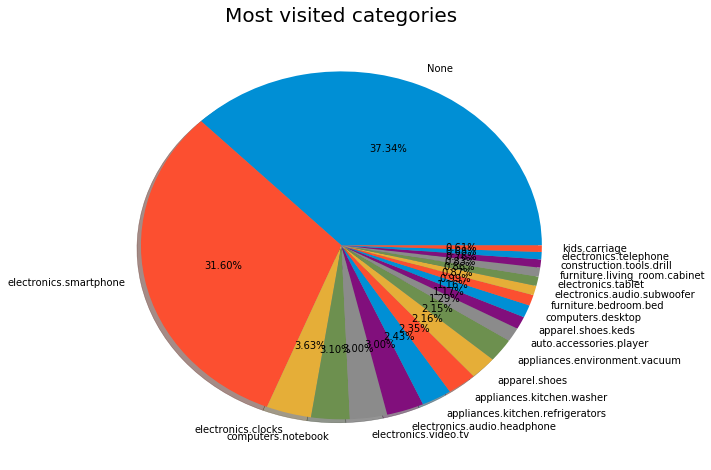

In [19]:
labels = cat_df_pd['category_code']
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(cat_df_pd['Nb of visitors'], shadow = True, labels = labels, autopct = '%.2f%%')
plt.title('Most visited categories', fontsize = 20)
plt.axis('off')
plt.show()

- **What are ranges of prices of products based on customers behaviours?**

In [18]:
sales_event_df = df.select(['event_type', 'price']) 

In [36]:
sales_event_df = sales_event_df.toPandas()
purchase = sales_event_df.filter(sales_event_df['event_type']=='purchase')
view = sales_event_df.filter(sales_event_df['event_type']=='view')
card = sales_event_df.filter(sales_event_df['event_type']=='cart')
data = [purchase.select(['price']).toPandas().values, view.select(['price']).toPandas().values, card.select(['price']).toPandas().values]

/home/dba/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


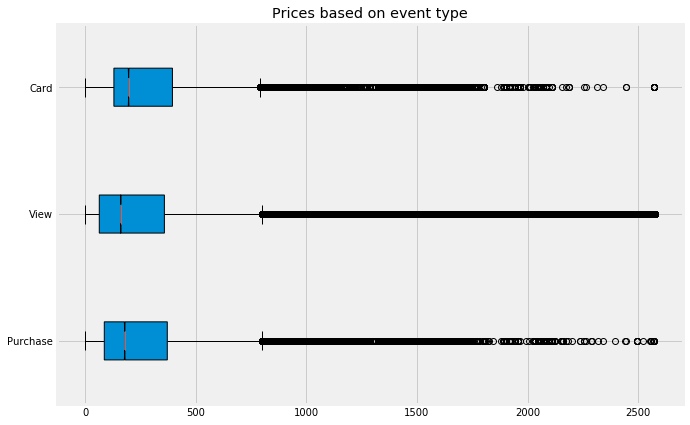

In [37]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, notch ='True', vert = 0)
# x-axis labels
ax.set_yticklabels(['Purchase', 'View','Card'])
# Adding title
plt.title("Prices based on event type")
plt.show()

In [21]:
sales_event_df = df.select(['event_type', 'price'])
sales_event_df = sales_event_df.groupBy('event_type').agg(sum('price').alias('sales')).sort(col('sales').desc())
sales_event_df .show()

+----------+--------------------+
|event_type|               sales|
+----------+--------------------+
|      view| 1.313920427179997E9|
|      cart|3.3421070760000005E7|
|  purchase| 2.671638162000001E7|
+----------+--------------------+



<p style="background-color:pink; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Preprocessing</b></p> 

### Feature Engineering :
- **`Principal Category`** : as the category_code is a combination of categories and subcategories, this new feature is about the first level one.
- **`Event Weekday`**: weekday of the event

### Encoding :
- Encode the three following columns :
    - `Brand`
    - `Principal Category`
    - `event_type`
    
### Visualizations after Preprocessing

### Train-Test Split : 
- 80% for train set and 20% for test set

### Feature Engineering :

In [38]:
# helper function to extract the principal category
def extract_principal_cat(x,i) :
    if x :
        return x.split('.')[i]
    else :
        return 'Not Provided'

In [39]:
# create a new column with the previous helper function
udf_star_desc = udf(lambda x:extract_principal_cat(x,0),StringType())
df = df.withColumn("Principal Category",udf_star_desc(col("category_code")))
df.show(5)

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|Principal Category|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+
|2019-10-19 11:13:...|      view|   1004767|2053013555631882655|electronics.smart...|samsung| 249.86|561610048|0000de39-dc74-414...|       electronics|
|2019-10-23 08:56:...|      view|   1005074|2053013555631882655|electronics.smart...|samsung|1149.08|536813317|00029324-8160-401...|       electronics|
|2019-10-05 11:54:...|      view|   1004446|2053013555631882655|electronics.smart...|samsung|  89.32|518029613|00041137-4a55-41a...|       electronics|
|2019-10-18 17:14:...|      view|   1801899|2053013554415534427|electronics.video.tv|sam

In [40]:
# create the event_weekday column based on the event_time
udf_star_desc = udf(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df = df.withColumn("Event Weekday",udf_star_desc(col("event_time")))
df.show(5)

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|Principal Category|Event Weekday|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+
|2019-10-19 11:13:...|      view|   1004767|2053013555631882655|electronics.smart...|samsung| 249.86|561610048|0000de39-dc74-414...|       electronics|            5|
|2019-10-23 08:56:...|      view|   1005074|2053013555631882655|electronics.smart...|samsung|1149.08|536813317|00029324-8160-401...|       electronics|            2|
|2019-10-05 11:54:...|      view|   1004446|2053013555631882655|electronics.smart...|samsung|  89.32|518029613|00041137-4a55-41a...|       electronics|            5|
|201

In [41]:
# change the type of weekday to int
df = df.withColumn("Event Weekday", df['Event Weekday'].cast('int'))

In [42]:
# get the set of all columns after feature engineering part
df.columns

['event_time',
 'event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'Principal Category',
 'Event Weekday']

### Encoding

In [43]:
# encode the brand column
brand_indexer = StringIndexer(inputCol='brand', outputCol='brand_index')
df = brand_indexer.setHandleInvalid("skip").fit(df).transform(df)
df.show(5)

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+-----------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|Principal Category|Event Weekday|brand_index|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+-----------+
|2019-10-19 11:13:...|      view|   1004767|2053013555631882655|electronics.smart...|samsung| 249.86|561610048|0000de39-dc74-414...|       electronics|            5|        0.0|
|2019-10-23 08:56:...|      view|   1005074|2053013555631882655|electronics.smart...|samsung|1149.08|536813317|00029324-8160-401...|       electronics|            2|        0.0|
|2019-10-05 11:54:...|      view|   1004446|2053013555631882655|electronics.smart...|samsung|  89.32|518029613

In [44]:
# encode the prncipal category column
cat_indexer = StringIndexer(inputCol='Principal Category', outputCol='Principal Category Index')
df = cat_indexer.setHandleInvalid("skip").fit(df).transform(df)

In [45]:
# use the one hot encoding as the number of categories is not too big (for overfitting purpose)
catEncoder = OneHotEncoder(inputCol="Principal Category Index", outputCol="Principal Category encoded")
df = catEncoder.transform(df)
df.show(5)

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+-----------+------------------------+--------------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|Principal Category|Event Weekday|brand_index|Principal Category Index|Principal Category encoded|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+-----------+------------------------+--------------------------+
|2019-10-19 11:13:...|      view|   1004767|2053013555631882655|electronics.smart...|samsung| 249.86|561610048|0000de39-dc74-414...|       electronics|            5|        0.0|                     0.0|            (13,[0],[1.0])|
|2019-10-23 08:56:...|      view|   1005074|2053013555631882655|electronics.smar

In [46]:
# encode the target column
event_indexer = StringIndexer(inputCol='event_type', outputCol='label')
df = event_indexer.setHandleInvalid("skip").fit(df).transform(df)
df.show(5)

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+-----------+------------------------+--------------------------+-----+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|Principal Category|Event Weekday|brand_index|Principal Category Index|Principal Category encoded|label|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+------------------+-------------+-----------+------------------------+--------------------------+-----+
|2019-10-19 11:13:...|      view|   1004767|2053013555631882655|electronics.smart...|samsung| 249.86|561610048|0000de39-dc74-414...|       electronics|            5|        0.0|                     0.0|            (13,[0],[1.0])|  0.0|
|2019-10-23 08:56:...|      view|   1005074|205301355563

### Visualizations after Preprocessing :

- **Number of buyers for each principal categoty** :

In [47]:
principal_categories_df = df.select(['user_id', 'category_code','Principal Category'])
# get the number of buyers for each principal category
principal_categories_df = principal_categories_df.groupBy('Principal Category').agg(count('user_id').alias('Nb of buyers'))
principal_categories_df.show(5)

+------------------+------------+
|Principal Category|Nb of buyers|
+------------------+------------+
|          medicine|        1539|
|         computers|      247989|
|              auto|       84995|
|        stationery|         647|
|             sport|       17062|
+------------------+------------+
only showing top 5 rows



In [48]:
print(f'Their are {principal_categories_df.count()} principal category in our dataset.')

Their are 14 principal category in our dataset.


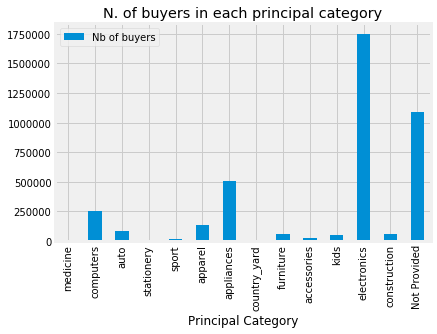

In [58]:
# let's visualize the number of buyers for each principal category
principal_categories_df.toPandas().plot(kind='bar', x='Principal Category')
plt.title('N. of buyers in each principal category')
plt.show()

- **In which day customers look for products more during the week?**

In [59]:
week_df = df.select(['user_id', 'Event Weekday'])
# get the number of buyers for each principal category
week_df = week_df.groupBy('Event Weekday').agg(count('user_id').alias('Nb of customers'))
week_df.show(5)

+-------------+---------------+
|Event Weekday|Nb of customers|
+-------------+---------------+
|            1|         644477|
|            6|         555826|
|            3|         606198|
|            5|         532028|
|            4|         550531|
+-------------+---------------+
only showing top 5 rows



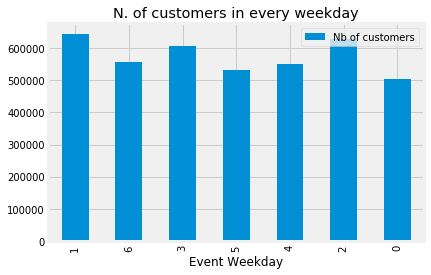

In [65]:
# let's visualize the number of buyers for each weekday
week_df.toPandas().plot(kind='bar', x='Event Weekday')
plt.title('N. of customers in every weekday')
plt.show()

### Train-Test Split :

In [66]:
# keep just important features in our dataset
df = df.select(['brand_index', 'price', 'Event Weekday', 'Principal Category encoded','label'])

In [67]:
# split our dataset with 80% of data for trainset and 20% for testset
(train, test )= df.randomSplit([0.8, 0.2], seed=42)

In [68]:
# create a new column with all independant variables in a single vector
assembler = VectorAssembler(inputCols=['brand_index', 'price', 'Event Weekday', 'Principal Category encoded'], outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [69]:
# Number of records in train and test sets
[train.count(), test.count()]

[3219332, 803776]

<p style="background-color:pink; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Training & Evaluation</b></p> 

### Logistic Regression :
- **Metrics** :
    - `F1 score` : 0.93
    - `Accuracy` : 0.95
 
### Decision Tree Classifier :
- **Metrics** :
    - `F1 score` : 0.93
    - `Accuracy` : 0.95
    
### Random Forest Classifier :
- **Metrics** :
    - `F1 score` : 0.93
    - `Accuracy` : 0.95

### Naive Bayes :
- **Metrics** :
    - `F1 score` : 0.58
    - `Accuracy` : 0.44
    
**`Conclusion`** :

It appears that the first three models are all good with approximately the same metrics (difference in numbers after comma), with an f1-score of 93% and an accuracy of 95%.

### Logistic Regression :

In [70]:
#Create and fit a Logistic Regression classifier.
lr = LogisticRegression(labelCol = "label", featuresCol = "features")
lr = lr.fit(train)

In [72]:
preds_LR = lr.transform(test)

In [77]:
# evaluate our modele
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

acc = evaluator.evaluate(preds_LR, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(preds_LR, {evaluator.metricName: "f1"}) 

In [78]:
print(f'F1 for test set is           : {f1}')
print(f'The accuracy for test set is : {acc}')

F1 for test set is           : 0.934000789601444
The accuracy for test set is : 0.9556655087984712


### Decision Tree Classifier :

In [80]:
# create and fit the model
dTree = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=7000)
dTree = dTree.fit(train)

In [81]:
# get the predictions
preds_DT = dTree.transform(train)

In [83]:
# get metrics for the model
acc = evaluator.evaluate(preds_DT, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(preds_DT, {evaluator.metricName: "f1"}) 

print(f'F1 for test set is           : {f1}')
print(f'The accuracy for test set is : {acc}')

F1 for test set is           : 0.9339716303718011
The accuracy for test set is : 0.955645767507048


### Random Forest :

In [85]:
# create and fit a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, maxBins=7000)
rf = rf.fit(train)

In [86]:
# get predictions
preds_RF = rf.transform(test)

In [92]:
# get metrics for the model
acc = evaluator.evaluate(preds_RF, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(preds_RF, {evaluator.metricName: "f1"}) 

print(f'F1 for test set is           : {f1}')
print(f'The accuracy for test set is : {acc}')

F1 for test set is           : 0.934000789601444
The accuracy for test set is : 0.9556655087984712


### Naive Bayes :

In [93]:
from pyspark.ml.classification import NaiveBayes

# create and fit the trainer and set its parameters
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0, modelType="multinomial")
nb_model = nb.fit(train)

In [94]:
# get predictions
preds_NB = nb_model.transform(test)

In [95]:
# get metrics for the model
acc = evaluator.evaluate(preds_NB, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(preds_NB, {evaluator.metricName: "f1"}) 

print(f'F1 for test set is           : {f1}')
print(f'The accuracy for test set is : {acc}')

F1 for test set is           : 0.583154255713681
The accuracy for test set is : 0.44213935225734535
